###  MicroGrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [3]:
np.random.seed(1337)
random.seed(1337)

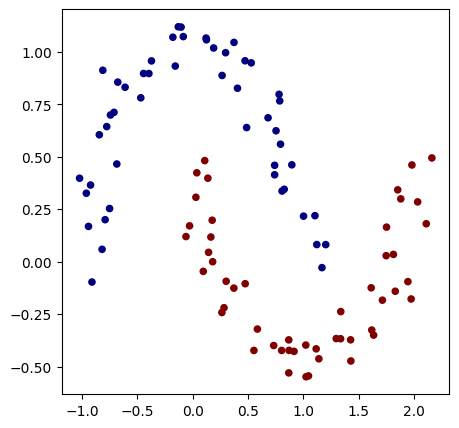

In [ ]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1

# Visualize the dataset in 2D space
# - X[:,0] are the x-coordinates, X[:,1] are the y-coordinates
# - c=y colors the points by their class label
# - cmap='jet' uses a color map (blue for -1, red for +1)
# - s=20 sets the size of the scatter points
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

# Note on SVM (Support Vector Machine):
# SVM is a classification algorithm that tries to find the best boundary 
# (hyperplane) that separates different classes with maximum margin.
# The "max-margin" loss used in this notebook is inspired by SVM:
# - It penalizes predictions that are on the wrong side of the boundary
# - It also penalizes correct predictions that are too close to the boundary
# - The loss formula: max(0, 1 - y*score) means:
#   * If y*score > 1: no loss (correct and confident)
#   * If y*score < 1: loss increases (wrong or not confident enough)
# This encourages the model to not just classify correctly, but to classify
# with a "margin" of confidence.

In [6]:
# initialize a model 

# Create a Multi-Layer Perceptron (MLP) neural network
# Architecture: MLP(2, [16, 16, 1])
# - Input layer: 2 neurons (for the 2 features: x and y coordinates)
# - Hidden layer 1: 16 neurons with ReLU activation
# - Hidden layer 2: 16 neurons with ReLU activation  
# - Output layer: 1 neuron with Linear activation (for binary classification)
#
# The network structure:
#   Input(2) → Dense(16, ReLU) → Dense(16, ReLU) → Dense(1, Linear)
#
# Note: "Dense" means "fully connected layer" - every neuron in one layer
# connects to every neuron in the next layer. Also called "Linear" layer.
# In this micrograd implementation, it's called a "Layer" of "Neurons".
#
# Visual diagram of the MLP architecture:
#
#     INPUT          HIDDEN 1        HIDDEN 2         OUTPUT
#                    (ReLU)          (ReLU)          (Linear)
#
#      x ────┐      ┌─── n1 ───┐    ┌─── n1 ───┐
#            ├──────┼─── n2 ───┼────┼─── n2 ───┼────┐
#      y ────┘      ├─── n3 ───┤    ├─── n3 ───┤    │
#                   ├─── n4 ───┤    ├─── n4 ───┤    ├──── score
#      (2)          ├─── ... ──┤    ├─── ... ──┤    │
#                   ├─── n15 ──┤    ├─── n15 ──┤    │
#                   └─── n16 ──┘    └─── n16 ──┘    │
#                                                     │
#                     (16)            (16)           (1)
#
# Each line represents connections (weights)
# Total connections: 2×16 + 16×16 + 16×1 = 32 + 256 + 16 = 304 weights
# Plus biases: 16 + 16 + 1 = 33 biases
# Total parameters: 337
#
# This is a 2-layer neural network (counting hidden layers, not including input)
model = MLP(2, [16, 16, 1])

print(model)
print("number of parameters", len(model.parameters()))

# Parameters breakdown:
# - Layer 1: (2 inputs × 16 neurons) + 16 biases = 48 parameters
# - Layer 2: (16 inputs × 16 neurons) + 16 biases = 272 parameters
# - Layer 3: (16 inputs × 1 neuron) + 1 bias = 17 parameters
# Total: 48 + 272 + 17 = 337 parameters
#
# Each parameter (weight or bias) will be learned during training
# to find the best decision boundary that separates the two moon classes

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [7]:
# loss function

# This function computes the loss (error) of the model's predictions
# It uses SVM "max-margin" loss with L2 regularization

def loss(batch_size=None):
    
    # inline DataLoader :)
    # This creates mini-batches for training
    # If batch_size=None, use all data (full batch)
    # Otherwise, randomly sample batch_size examples
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    # Convert numpy arrays to Value objects for autograd
    # Each row of Xb becomes a list of Value objects
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    # Run each input through the neural network
    # scores[i] is the model's prediction for sample i
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    # For each sample: max(0, 1 - y*score)
    # - If y=1 and score=2: loss = max(0, 1-2) = 0 (correct & confident)
    # - If y=1 and score=0.5: loss = max(0, 1-0.5) = 0.5 (correct but not confident)
    # - If y=1 and score=-1: loss = max(0, 1-(-1)) = 2 (wrong prediction)
    # .relu() implements max(0, x)
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    
    # Average loss across all samples in the batch
    data_loss = sum(losses) * (1.0 / len(losses))
    
    # L2 regularization
    # Penalize large weights to prevent overfitting
    # alpha controls the strength of regularization
    # Sum of squared weights: w1² + w2² + ... + wn²
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    
    # Total loss = data loss + regularization loss
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    # Check if sign of prediction matches sign of true label
    # (yi > 0) is True if yi=1, False if yi=-1
    # (scorei.data > 0) is True if prediction is positive
    # Compare them to get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

# Test the loss function
total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.2606891092765604, grad=0) 0.24


In [8]:
# optimization

# This is the training loop that updates the model's parameters
# to minimize the loss function using Stochastic Gradient Descent (SGD)

for k in range(100):
    
    # Forward pass
    # Compute the loss and accuracy for the current model
    total_loss, acc = loss()
    
    # Backward pass
    # First, zero out all gradients from the previous iteration
    # (gradients accumulate by default, so we need to reset them)
    model.zero_grad()
    
    # Compute gradients using backpropagation
    # This calculates ∂loss/∂w for every parameter w in the network
    # The .backward() method is the core of automatic differentiation
    total_loss.backward()
    
    # Update (SGD - Stochastic Gradient Descent)
    # Move each parameter in the opposite direction of its gradient
    # Learning rate controls the step size
    # Formula: w_new = w_old - learning_rate * gradient
    #
    # Learning rate schedule: starts at 1.0, decays to 0.1 over 100 steps
    # This helps the model converge more smoothly
    # Early: large steps for fast learning
    # Late: small steps for fine-tuning
    learning_rate = 1.0 - 0.9*k/100
    
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    # Print progress every iteration
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

# Training summary:
# - Starts with ~50% accuracy (random guessing)
# - Loss decreases from ~0.9 to ~0.01
# - Accuracy improves to 100%
# - The model learns to separate the two moon-shaped clusters
#
# The three steps (forward, backward, update) form the core training loop
# used in virtually all neural network training

step 0 loss 1.2606891092765604, accuracy 24.0%
step 1 loss 0.9442463519767778, accuracy 78.0%
step 2 loss 0.41078667004561353, accuracy 83.0%
step 3 loss 0.3379238727847243, accuracy 87.0%
step 4 loss 0.29089823651799285, accuracy 88.0%
step 5 loss 0.25812466062214995, accuracy 91.0%
step 6 loss 0.24635683434457753, accuracy 89.0%
step 7 loss 0.35128563599764, accuracy 90.0%
step 8 loss 0.5500432035581851, accuracy 82.0%
step 9 loss 0.4200738714474908, accuracy 86.0%
step 10 loss 0.28142665110081905, accuracy 87.0%
step 11 loss 0.22280628266127714, accuracy 89.0%
step 12 loss 0.1884734066940054, accuracy 92.0%
step 13 loss 0.20208522257949715, accuracy 92.0%
step 14 loss 0.2069394557936187, accuracy 92.0%
step 15 loss 0.24853999671926388, accuracy 90.0%
step 16 loss 0.1614917154891424, accuracy 92.0%
step 17 loss 0.1530069156364768, accuracy 93.0%
step 18 loss 0.1557415451403155, accuracy 92.0%
step 19 loss 0.15819656536268287, accuracy 94.0%
step 20 loss 0.18569575058108684, accuracy 

(-1.548639298268643, 1.951360701731357)

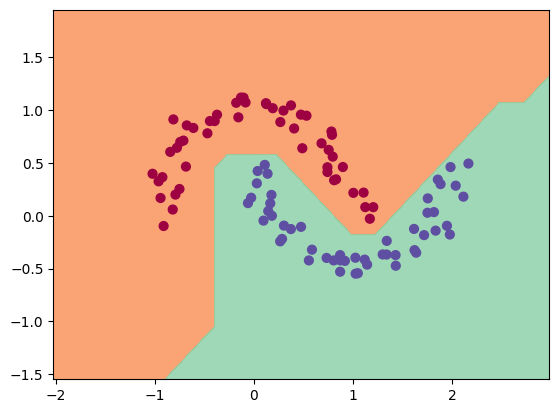

In [9]:
# visualize decision boundary

# This creates a visualization showing how the trained model
# divides the 2D space into regions for each class

# Step 1: Create a grid of points covering the entire plot area
# h is the step size (resolution) of the grid
h = 0.25

# Find the min/max values of x and y coordinates, add padding of 1
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# np.meshgrid creates a 2D grid of coordinates
# xx contains x-coordinates, yy contains y-coordinates
# Example: if x ranges 0-2 with step 1, and y ranges 0-2 with step 1:
#   xx = [[0, 1, 2],    yy = [[0, 0, 0],
#         [0, 1, 2],          [1, 1, 1],
#         [0, 1, 2]]          [2, 2, 2]]
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Step 2: Flatten the grid into a list of (x, y) points
# np.c_ concatenates arrays column-wise
# .ravel() flattens 2D arrays into 1D
# Xmesh becomes array of points: [[x1,y1], [x2,y2], ...]
Xmesh = np.c_[xx.ravel(), yy.ravel()]

# Step 3: Run the model on every point in the grid
# Convert each point to Value objects (required by micrograd)
inputs = [list(map(Value, xrow)) for xrow in Xmesh]

# Get model predictions for all grid points
scores = list(map(model, inputs))

# Step 4: Convert scores to binary predictions (0 or 1)
# If score > 0: class 1 (True)
# If score < 0: class 0 (False)
Z = np.array([s.data > 0 for s in scores])

# Reshape back to the original grid shape for plotting
Z = Z.reshape(xx.shape)

# Step 5: Plot the decision boundary
fig = plt.figure()

# plt.contourf creates a filled contour plot (colored regions)
# This colors the background based on the model's predictions
# Blue regions = model predicts class -1
# Red regions = model predicts class +1
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)

# Overlay the actual training data points on top
# This shows how well the decision boundary separates the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)

# Set the plot limits
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# The result shows:
# - Colored background regions (model's classification for each point in space)
# - Actual data points (colored by their true labels)
# - The boundary between regions is the "decision boundary"
# - If training worked well, data points should match their background color